In [34]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(rc={'figure.figsize':(25,10)})

In [35]:
### Input mutation files

# mutation call positions wrt to the parental_stock.conensus.fasta 
fname_mutations_wild_type = '../../resources/run_workflow/results_cluster/wild_type/all_mutations.annotated.csv'
fname_mutations_ko = '../../resources/run_workflow/results_cluster/dicer_KO/all_mutations.annotated.csv'
fname_mutations_overexpressed = '../../resources/run_workflow/results_cluster/dicer_overexpression/all_mutations.annotated.csv'

# mutation call positions wrt to the EB reference
fname_parental = '../../resources/run_workflow/results_cluster/parental_stock_ref_EBref/all_mutations.annotated.csv'

In [39]:
# adapt positions of mutation calls such that all is wrt the EB-reference space
# parental_stock.conensus.fasta 
#
# We are adjusting the parental_stock.consensus.bcftools.fasta sequence such that it excludes the UTRs. 
# This means we exclude positions [0,24] and [9102, 9263] -- those positions all have less than 9999 coverage.

df_wild_type = pd.read_csv(fname_mutations_wild_type)
df_wild_type = df_wild_type.drop(['Unnamed: 0'], axis =1)
#df_wild_type['sample'] = 'wild_type'
df_wild_type['Pos'] = df_wild_type['POS'] + 25

df_ko = pd.read_csv(fname_mutations_ko)
df_ko = df_ko.drop(['Unnamed: 0'], axis =1)
#df_ko['sample'] = 'dicer_ko'
df_ko['Pos'] = df_ko['POS'] + 25

df_overexpressed = pd.read_csv(fname_mutations_overexpressed)
df_overexpressed = df_overexpressed.drop(['Unnamed: 0'], axis =1)
#df_overexpressed['sample'] = 'dicer_overexpressed'
df_overexpressed['Pos'] = df_overexpressed['POS'] + 25

# read in parental strain without shift of positions
df_parental = pd.read_csv(fname_parental)
df_parental = df_parental.drop(['Unnamed: 0'], axis =1)
df_parental['genotype'] = 'aaa_parental_stock'
df_parental['replicate'] = '0'
df_parental['passage'] = '0'
df_parental['Pos'] = df_parental['POS']

In [40]:
# dataframe with all mutations from all samples
df = pd.concat([df_ko, df_overexpressed, df_wild_type, df_parental])

# add information
df['Freq1'] = pd.to_numeric(df['Freq1'], errors='coerce')
df['Freq2'] = pd.to_numeric(df['Freq2'], errors='coerce')
df['Freq3'] = pd.to_numeric(df['Freq3'], errors='coerce')

df['n_reads_var'] = df['Rvar'] + df['Fvar']
df['n_reads_tot'] = df['Rtot'] + df['Ftot']
df['frequency_reads_var'] = df['n_reads_var'] / df['n_reads_tot']
df['Frq_ave'] = df[['Freq1','Freq2','Freq3']].mean(axis=1)

df['passage'] = df['passage'].str.split('_').str[-1].astype('float')

# filter for non-synonymous mutations
df = df[df['IsSynonymous']==0]

df.to_csv('./non_synonymous_mutations/non_synonymous_mutations_all_samples_incl_parental.csv')

In [41]:
# Post-processing filtering of mutation calling

# filter out where Frq_ave == 0.0 
# that is something unexpected happening in ShoRAH which is due to the super high coverage
df = df[df['Frq_ave']!=0]

# strand bias test 
df = df[df['Pval']>=0.05]

# minimum read support
minimum_read_support = 10 
df = df[df['n_reads_var']>=minimum_read_support]

In [46]:
# Filtering for the heatmap plots

# filter mutations that only occurr in one sample 
#unique_position_lists = np.unique(df['Pos'], return_counts = True)
#indx = np.argwhere(unique_position_lists[1]>1)
#multi_occurrence_positions = unique_position_lists[0][indx].flatten()
#df = df[df['Pos'].isin(multi_occurrence_positions)]

# minimum_frequency_threshold = 0.01
#df = df[df['frequency_reads_var']>=minimum_frequency_threshold]

# filter out mutations that show never a frequency >= 0.1 in any sample
frequency_threshold = 0.01
df_temp = df[df['frequency_reads_var']>=frequency_threshold]
df_temp = df_temp[df_temp['genotype']!='aaa_parental_stock']
high_freq_positions = df_temp['Pos'].values

df = df[df['Pos'].isin(high_freq_positions)]

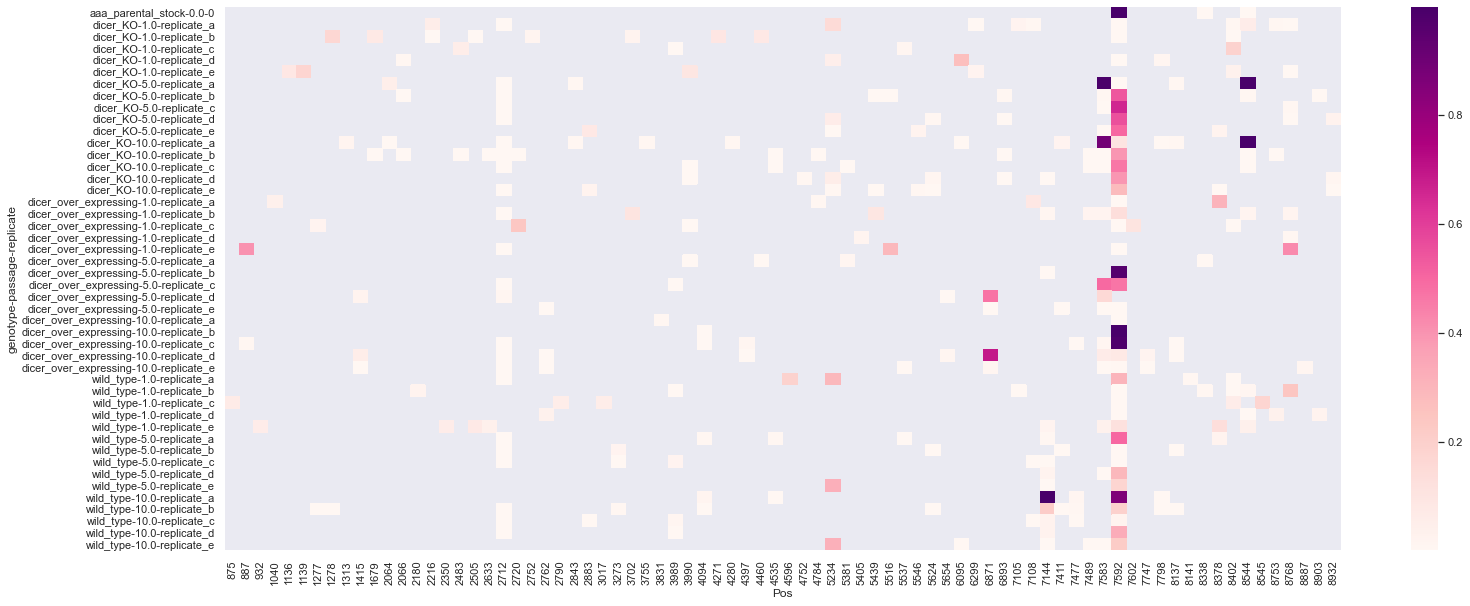

In [47]:
# Pivot table 
df_heatmap = df[['genotype', 'replicate', 'passage', 'Pos', 'frequency_reads_var']]
df_heatmap = df_heatmap.pivot_table(values='frequency_reads_var', 
                                    index=[ 'genotype', 'passage', 'replicate'], 
                                    columns='Pos'
                                   )

positions = df_heatmap.columns.to_list()

# plot heatmap in normal scale

g = sns.heatmap(df_heatmap, xticklabels = positions, cmap="RdPu")
fig = g.get_figure()
fig.savefig("./non_synonymous_mutations/Heatmap_non_synonymous_mutations.freq_thres0.01.pdf") 

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_78352/1320498630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_heatmap['frequency_reads_var_log'] = np.log10(df_heatmap['frequency_reads_var'])


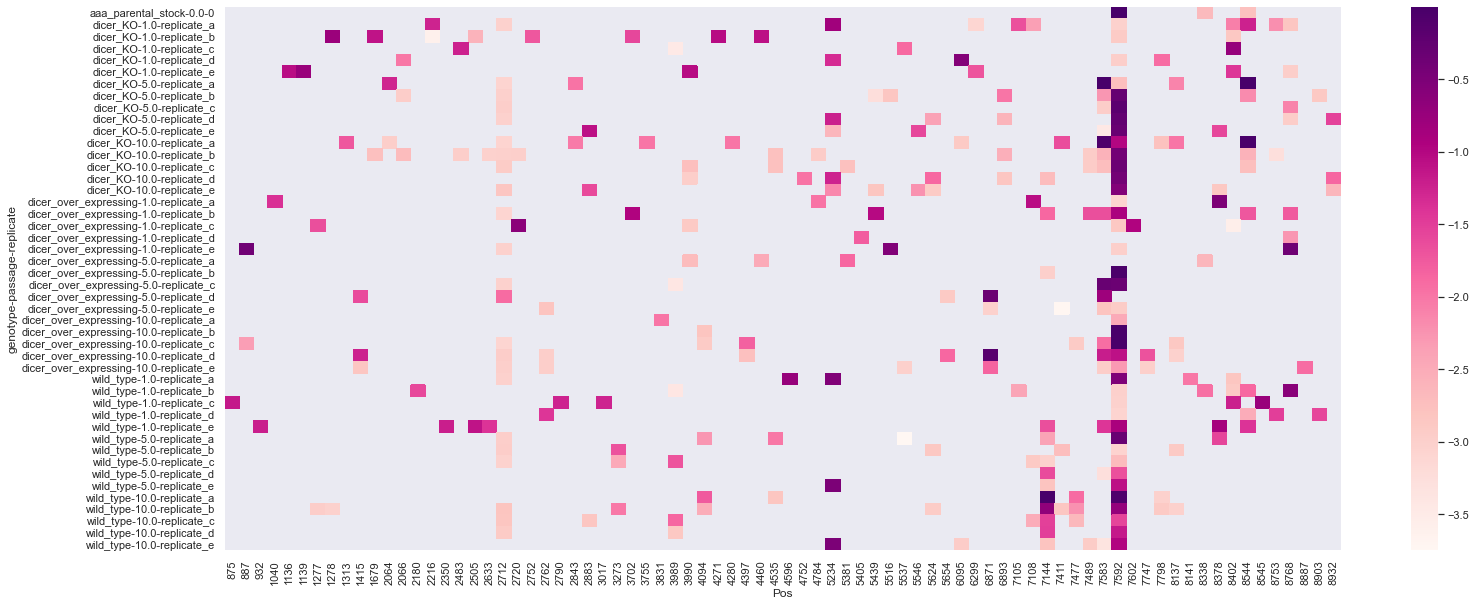

In [48]:
# plot heatmap in log10 scale
df_heatmap = df[['genotype', 'replicate', 'passage', 'Pos', 'frequency_reads_var']]
df_heatmap['frequency_reads_var_log'] = np.log10(df_heatmap['frequency_reads_var'])

df_heatmap = df_heatmap.pivot_table(values='frequency_reads_var_log', 
                                    index=[ 'genotype', 'passage', 'replicate'], 
                                    columns='Pos'
                                   )

positions = df_heatmap.columns.to_list()

g = sns.heatmap(df_heatmap, xticklabels = positions, cmap="RdPu")
fig = g.get_figure()
fig.savefig("./non_synonymous_mutations/Heatmap_non_synonymous_mutations.freq_thres0.01.log.pdf") 